In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os 

import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import groupby
import gc



from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

np.random.seed(0)
pd.set_option('display.precision', 2)  
pd.set_option('display.float_format', '{:.2f}'.format) 

In [121]:
current_directory = os.getcwd()

csv_file_path = os.path.join(current_directory, 'input', 'data', 'train_events.csv')

train_events  = pd.read_csv(csv_file_path)

series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
train_ids = series_has_nan[~series_has_nan].index.tolist()


In [122]:
current_directory = os.getcwd()

parquet_file_path = os.path.join(current_directory, 'input', 'light_weight_data', 'Zzzs_train_multi.parquet')



def get_multi_light_series(series_ids):
    print(f'fetch {series_ids} \n')
    multi_series = pd.read_parquet(parquet_file_path, filters=[('series_id','in',series_ids)])
    multi_series = multi_series.astype({'series_id':'category','step':'int16','awake': 'int16'})
    multi_series =  add_features(multi_series)
    return multi_series



def add_features(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"],utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek

    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]

    periods = 6 # 1/2 minute
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
    df["enmo_diff"]   = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill")
    
    df["anglez_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
    df["enmo_mean"]   = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
    
    df["anglez_min"] = df["anglez"].rolling(periods,center=True).min().fillna(method="bfill").fillna(method="ffill").astype('float32')
    df["enmo_min"]   = df["enmo"].rolling(periods,center=True).min().fillna(method="bfill").fillna(method="ffill").astype('float32')
    
    df["anglez_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float32')
    df["enmo_max"]   = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float32')
    
    df["anglez_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float32')
    df["enmo_std"]   = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float32')
    
    df["anglez_diff_rolling"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
    df["enmo_diff_rolling"]   = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
    return df

In [123]:
train_all = get_multi_light_series(train_ids[:8])
print(f'memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB')

fetch ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_50507/2488440551.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_50507/2488440551.py:24: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_50507/2488440551.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_50507/2488440551.py:25: FutureWarning:

Series.fillna with 'method' is deprecated

memory usage:  219.76 MB


/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_50507/2488440551.py:40: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [124]:
current_directory = os.getcwd()

parquet_file_path = os.path.join(current_directory, 'input', 'light_weight_data', 'Zzzs_train.parquet')

example = pd.read_parquet(parquet_file_path)

gc.collect()

0

In [125]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train_all, test_size=0.2)

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


features = ["step", "hour","dayofweek","anglez_times_enmo",
            "anglez","anglez_diff","anglez_mean","anglez_min","anglez_max","anglez_std","anglez_diff_rolling",
            "enmo","enmo_diff","enmo_mean","enmo_min","enmo_max","enmo_std","enmo_diff_rolling"]
target = 'awake'



lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
lr_pipeline.fit(train_set[features], train_set[target])

gc.collect()

52

### Logistic Regression

In [127]:
lr_predictions = lr_pipeline.predict(test_set[features])

accuracy = np.mean(lr_predictions == test_set[target])
print("Accuracy:", accuracy)


Accuracy: 0.887753523849696


In [151]:
roc_auc = roc_auc_score(test_set[target], lr_pipeline.predict_proba(test_set[features])[:,-1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9271017339066483


In [129]:
from sklearn.metrics import classification_report

print(classification_report(test_set[target], lr_pipeline.predict(test_set[features]), target_names=['sleep onset', 'wake']))

              precision    recall  f1-score   support

 sleep onset       0.79      0.90      0.84    187124
        wake       0.95      0.88      0.91    381856

    accuracy                           0.89    568980
   macro avg       0.87      0.89      0.88    568980
weighted avg       0.89      0.89      0.89    568980



### RandomForestClassifier

In [130]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, min_samples_leaf=25, random_state=42, n_jobs=-1)
)

# Fit the pipeline to your training data
rf_pipeline.fit(train_set[features], train_set[target])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=25, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [131]:
rf_predictions = rf_pipeline.predict(test_set[features])

accuracy = np.mean(rf_predictions == test_set[target])
print("Accuracy:", accuracy)

Accuracy: 0.9748567612218355


In [154]:
roc_auc = roc_auc_score(test_set[target], rf_pipeline.predict_proba(test_set[features])[:,-1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9973356402824681


In [133]:
from sklearn.metrics import classification_report

print(classification_report(test_set[target], rf_pipeline.predict(test_set[features]), target_names=['sleep onset', 'wake']))

              precision    recall  f1-score   support

 sleep onset       0.96      0.96      0.96    187124
        wake       0.98      0.98      0.98    381856

    accuracy                           0.97    568980
   macro avg       0.97      0.97      0.97    568980
weighted avg       0.97      0.97      0.97    568980



In [134]:
px.bar(x=features, 
       y=rf_pipeline[1].feature_importances_,
       title='RandomForestClassifier feature importances'
      )

### LGBMClassifier

In [135]:
import lightgbm as lgbm

lgbm_pipeline = make_pipeline(
    StandardScaler(),
    lgbm.LGBMClassifier(n_estimators=100, boosting_type='gbdt', random_state=42, n_jobs=-1)
)

lgbm_pipeline.fit(train_set[features], train_set[target])



[LightGBM] [Info] Number of positive: 1523756, number of negative: 752164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4113
[LightGBM] [Info] Number of data points in the train set: 2275920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.669512 -> initscore=0.705979
[LightGBM] [Info] Start training from score 0.705979


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(n_jobs=-1, random_state=42))])

In [136]:
lgbm_predictions = lgbm_pipeline.predict(test_set[features])

accuracy = np.mean(lgbm_predictions == test_set[target])
print("Accuracy:", accuracy)

Accuracy: 0.9692115715842384


In [152]:
roc_auc = roc_auc_score(test_set[target], lgbm_pipeline.predict_proba(test_set[features])[:,1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9955370481779655


In [138]:
print(classification_report(test_set[target], lgbm_pipeline.predict(test_set[features]), target_names=['sleep onset', 'wake']))

              precision    recall  f1-score   support

 sleep onset       0.95      0.96      0.95    187124
        wake       0.98      0.97      0.98    381856

    accuracy                           0.97    568980
   macro avg       0.96      0.97      0.97    568980
weighted avg       0.97      0.97      0.97    568980



In [139]:
px.bar(x=features, 
       y=lgbm_pipeline[1].feature_importances_,
       title='LGBMClassifier feature importances'
      )

### DecisionTreeClassifier

In [140]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

dt_pipeline.fit(train_set[features], train_set[target])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [141]:
dt_predictions = dt_pipeline.predict(test_set[features])


accuracy = np.mean(dt_predictions == test_set[target])
print("Accuracy:", accuracy)

Accuracy: 0.9907975675770677


In [153]:
roc_auc = roc_auc_score(test_set[target], dt_pipeline.predict_proba(test_set[features])[:,1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9896693037344507


In [143]:
print(classification_report(test_set[target], dt_pipeline.predict(test_set[features]), target_names=['sleep onset', 'wake']))

              precision    recall  f1-score   support

 sleep onset       0.99      0.99      0.99    187124
        wake       0.99      0.99      0.99    381856

    accuracy                           0.99    568980
   macro avg       0.99      0.99      0.99    568980
weighted avg       0.99      0.99      0.99    568980



In [144]:
from sklearn.metrics import roc_curve, auc
# For Decision Tree
dt_probs = dt_pipeline.predict_proba(test_set[features])[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(test_set[target], dt_probs)
dt_auc = auc(dt_fpr, dt_tpr)

#For Logistic 
lr_probs = lr_pipeline.predict_proba(test_set[features])[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(test_set[target], lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

# For Random Forest
rf_probs = lgbm_pipeline.predict_proba(test_set[features])[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(test_set[target], rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

# For LightGBM
lgbm_probs = lgbm_pipeline.predict_proba(test_set[features])[:, 1]
lgbm_fpr, lgbm_tpr, _ = roc_curve(test_set[target], lgbm_probs)
lgbm_auc = auc(lgbm_fpr, lgbm_tpr)

In [146]:
px.bar(x=features, 
       y=dt_pipeline[1].feature_importances_,
       title='DecisionTreeClassifier feature importances'
      )

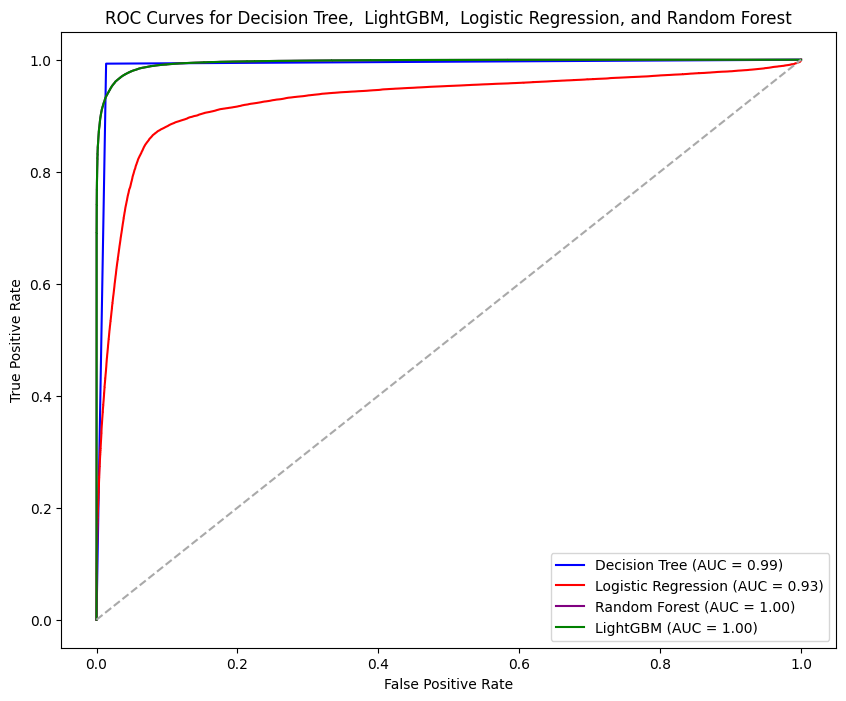

In [145]:
plt.figure(figsize=(10, 8))

# Plot ROC for Decision Tree
plt.plot(dt_fpr, dt_tpr, color='blue', label=f'Decision Tree (AUC = {dt_auc:.2f})')

# Plot ROC for Logistic 
plt.plot(lr_fpr, lr_tpr, color='red', label=f'Logistic Regression (AUC = {lr_auc:.2f})')

# Plot ROC for Random Forest
plt.plot(rf_fpr, rf_tpr, color='purple', label=f'Random Forest (AUC = {rf_auc:.2f})')

# Plot ROC for LightGBM
plt.plot(lgbm_fpr, lgbm_tpr, color='green', label=f'LightGBM (AUC = {lgbm_auc:.2f})')

# Plot ROC for a random model (baseline)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree,  LightGBM,  Logistic Regression, and Random Forest')
plt.legend()

plt.show()

### Over fitting check 

In [158]:
#logistic Regression

lr_scores = cross_val_score(lr_pipeline, train_set[features], train_set[target], cv=5, scoring='accuracy')

print("Accuracy scores for each fold are:", scores)
print("Mean accuracy:", scores.mean())

Accuracy scores for each fold are: [0.96816892 0.96850944 0.96831611 0.96861489 0.96876648]
Mean accuracy: 0.9684751660866814


In [159]:
#Random Forest

rf_scores = cross_val_score(rf_pipeline, train_set[features], train_set[target], cv=5, scoring='accuracy')

print("Accuracy scores for each fold are:", scores)
print("Mean accuracy:", scores.mean())

Accuracy scores for each fold are: [0.96816892 0.96850944 0.96831611 0.96861489 0.96876648]
Mean accuracy: 0.9684751660866814


In [160]:
#LGBM

lgbm_scores = cross_val_score(lgbm_pipeline, train_set[features], train_set[target], cv=5, scoring='accuracy')

print("Accuracy scores for each fold are:", scores)
print("Mean accuracy:", scores.mean())

[LightGBM] [Info] Number of positive: 1219005, number of negative: 601731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4113
[LightGBM] [Info] Number of data points in the train set: 1820736, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.669512 -> initscore=0.705980
[LightGBM] [Info] Start training from score 0.705980
[LightGBM] [Info] Number of positive: 1219005, number of negative: 601731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4113
[LightGBM] [Info] Number of data points in the train set: 1820736, number of used features: 18
[LightGBM]

In [161]:
# DecisionTreeClassifier

dt_scores = cross_val_score(dt_pipeline, train_set[features], train_set[target], cv=5, scoring='accuracy')

print("Accuracy scores for each fold are:", scores)
print("Mean accuracy:", scores.mean())

Accuracy scores for each fold are: [0.96816892 0.96850944 0.96831611 0.96861489 0.96876648]
Mean accuracy: 0.9684751660866814


In [83]:
from sklearn.metrics import accuracy_score


dt_pipeline.fit(train_set[features], train_set[target])

# Evaluate on training set
train_accuracy = accuracy_score(train_set[target], dt_pipeline.predict(train_set[features]))

# Evaluate on validation set
val_accuracy = accuracy_score(test_set[target], dt_pipeline.predict(test_set[features]))

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 1.0
Validation Accuracy: 0.9907975675770677


Training Accuracy: As the depth increases, the model can capture more details of the training data, often leading to higher training accuracy.
Validation/Test Accuracy: Initially, increasing depth might also improve validation/test accuracy, but after a certain point, further increasing depth can lead to overfitting. This is typically observed as a decrease or plateau in validation/test accuracy while training accuracy continues to increase.
Optimal Depth: The plot can help identify the optimal depth that maximizes validation/test accuracy while avoiding overfitting. This is often the point where the validation/test accuracy peaks or starts to diverge from the training accuracy.

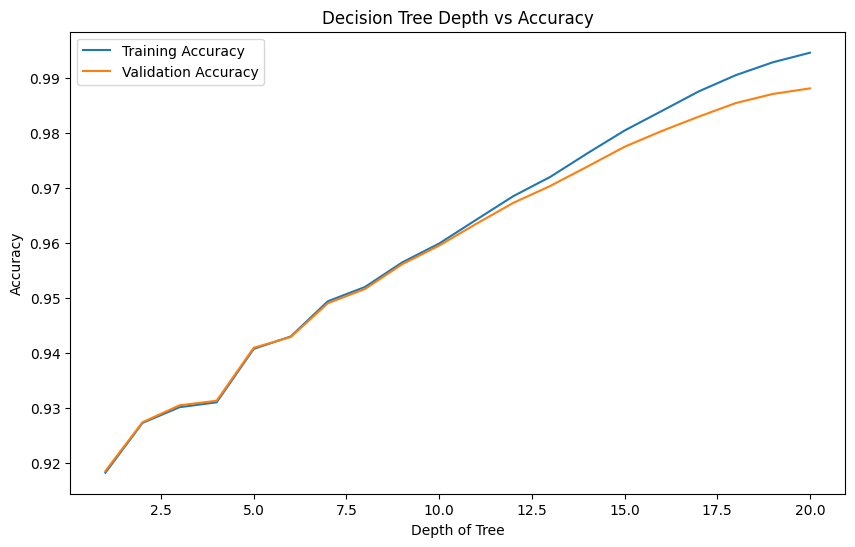

In [90]:
depths = range(1, 21)
train_accs, val_accs = [], []

for depth in depths:
    dt_pipeline = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(max_depth=depth, random_state=42)
    )
    dt_pipeline.fit(train_set[features], train_set[target])
    
    train_accs.append(accuracy_score(train_set[target], dt_pipeline.predict(train_set[features])))
    val_accs.append(accuracy_score(test_set[target], dt_pipeline.predict(test_set[features])))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs, label='Training Accuracy')
plt.plot(depths, val_accs, label='Validation Accuracy')
plt.title('Decision Tree Depth vs Accuracy')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()